In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from IPython.core.display    import HTML
from IPython.display         import Image
from tabulate                import tabulate
#from mpl_toolkits.basemap    import Basemap
from scipy.stats             import chi2_contingency

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost               as xgb
from sklearn import metrics

from sklearn.metrics         import mean_absolute_error, mean_squared_error

In [2]:
df = pd. read_csv('New_DB.csv',low_memory=False, error_bad_lines=False)

In [3]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
df.head(5)

,region,price,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,no_year
0,auburn,15000,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,rwd,truck,black,32.5920,-85.518900,7
1,auburn,27990,good,8 cylinders,gas,68696.0,clean,other,4wd,4wd,pickup,black,32.5900,-85.480000,8
2,auburn,34590,good,6 cylinders,gas,29499.0,clean,other,4wd,4wd,pickup,silver,32.5900,-85.480000,4
3,auburn,35000,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,4wd,truck,grey,32.6013,-85.443974,1
4,auburn,29990,good,6 cylinders,gas,17302.0,clean,other,4wd,4wd,pickup,red,32.5900,-85.480000,4


In [5]:
df.drop(['region'],axis=1,inplace=True)

In [6]:
num_attributes = df.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df.select_dtypes( exclude=['int64', 'float64'] )
num_attributes.sample()

,price,odometer,lat,long,no_year
121307,15990,150185.0,35.843,-78.632,8


In [7]:
cat_attributes.sample()

,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color
208255,excellent,4 cylinders,gas,clean,automatic,4wd,4wd,SUV,blue


In [8]:
cat_attributes['size'].unique()

array(['rwd', '4wd', 'fwd', 'mid-size'], dtype=object)

In [9]:
df['drive'].value_counts()

4wd    91811
fwd    77104
rwd    42651
Name: drive, dtype: int64

In [10]:
df = df[df['size'] != 'mid-size']

In [11]:
df['size'].value_counts()

4wd    92367
fwd    76454
rwd    42744
Name: size, dtype: int64

In [12]:
df.shape

(211565, 14)

In [13]:
df1 = df[df['size'] == df['drive']]

In [14]:
df1.shape

(209255, 14)

In [15]:
#Since both the drive type and size are matching I am gonna drop drive type
df1.drop(['drive'],axis=1,inplace=True)
df1.drop(['paint_color'],axis=1,inplace=True)

C:\Users\Elamathi\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
df1.head(5)

,price,condition,cylinders,fuel,odometer,title_status,transmission,size,type,lat,long,no_year
0,15000,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,32.5920,-85.518900,7
1,27990,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,32.5900,-85.480000,8
2,34590,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,32.5900,-85.480000,4
3,35000,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,32.6013,-85.443974,1
4,29990,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,32.5900,-85.480000,4


In [17]:
df1.drop(['lat'],axis=1,inplace=True)
df1.drop(['long'],axis=1,inplace=True)

C:\Users\Elamathi\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
print(df1['condition'].unique())
print(df1['type'].unique())
print(df1['transmission'].unique())
print(df1['fuel'].unique())
print(df1['size'].unique())
print(df1['title_status'].unique())

['excellent' 'good' 'new' 'like new' 'fair' 'salvage']
['truck' 'pickup' 'other' 'coupe' 'SUV' 'mini-van' 'sedan' 'hatchback'
 'offroad' 'convertible' 'van' 'wagon' 'bus']
['automatic' 'other' 'manual']
['gas' 'other' 'diesel' 'hybrid' 'electric']
['rwd' '4wd' 'fwd']
['clean' 'rebuilt' 'salvage' 'missing' 'lien' 'parts only']


In [19]:
final_dataset=pd.get_dummies(df1 ,drop_first=True)

In [19]:
final_dataset.head(5)

,price,odometer,lat,long,no_year,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,15000,128000.0,32.5920,-85.518900,7,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,27990,68696.0,32.5900,-85.480000,8,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,34590,29499.0,32.5900,-85.480000,4,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,35000,43000.0,32.6013,-85.443974,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,29990,17302.0,32.5900,-85.480000,4,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
cor_matrix = final_dataset.corr().abs()
print(cor_matrix)

                            price  odometer   no_year  condition_fair  \
price                    1.000000  0.226282  0.393922        0.087591   
odometer                 0.226282  1.000000  0.186131        0.081269   
no_year                  0.393922  0.186131  1.000000        0.142656   
condition_fair           0.087591  0.081269  0.142656        1.000000   
condition_good           0.087880  0.000021  0.028548        0.152088   
condition_like new       0.054695  0.035296  0.058402        0.066348   
condition_new            0.023222  0.011646  0.008529        0.011432   
condition_salvage        0.017545  0.006546  0.007221        0.012835   
cylinders_12 cylinders   0.004472  0.001175  0.020685        0.003924   
cylinders_3 cylinders    0.025749  0.014266  0.014378        0.007641   
cylinders_4 cylinders    0.292217  0.044302  0.138115        0.066278   
cylinders_5 cylinders    0.056329  0.011020  0.014609        0.000322   
cylinders_6 cylinders    0.029888  0.000652  0.0319

In [20]:
final_dataset.corr()

,price,odometer,no_year,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,cylinders_12 cylinders,cylinders_3 cylinders,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
price,1.000000,-0.226282,-0.393922,-0.087591,0.087880,0.054695,0.023222,0.017545,0.004472,-0.025749,...,0.056827,-0.110587,-0.083670,-0.003097,0.112365,0.253091,-0.262984,0.199686,0.007622,-0.064513
odometer,-0.226282,1.000000,0.186131,0.081269,-0.000021,-0.035296,-0.011646,0.006546,0.001175,-0.014266,...,-0.036532,-0.011640,0.022466,0.019371,-0.035374,0.006591,-0.019652,0.042234,0.000979,0.006734
no_year,-0.393922,0.186131,1.000000,0.142656,0.028548,-0.058402,-0.008529,0.007221,0.020685,-0.014378,...,0.135592,-0.025442,0.012114,0.063054,-0.034294,-0.022578,-0.038968,0.034941,-0.029824,-0.013040
condition_fair,-0.087591,0.081269,0.142656,1.000000,-0.152088,-0.066348,-0.011432,-0.012835,0.003924,-0.007641,...,-0.002119,-0.014061,-0.000394,0.004115,-0.017012,0.062555,-0.040670,0.063831,-0.009380,-0.012822
condition_good,0.087880,-0.000021,0.028548,-0.152088,1.000000,-0.265459,-0.045740,-0.051354,-0.000322,-0.017357,...,0.045253,0.005329,-0.028329,0.007238,0.122854,0.072812,-0.063017,0.034586,0.007088,-0.013381
condition_like new,0.054695,-0.035296,-0.058402,-0.066348,-0.265459,1.000000,-0.019954,-0.022403,0.002862,-0.003101,...,0.000444,0.003723,0.003055,0.001525,-0.029987,0.011383,0.008482,0.032136,-0.011953,-0.010625
condition_new,0.023222,-0.011646,-0.008529,-0.011432,-0.045740,-0.019954,1.000000,-0.003860,-0.001154,0.007637,...,0.001791,-0.001063,0.004065,-0.000342,-0.001232,-0.001899,0.006223,0.001690,-0.006760,-0.005995
condition_salvage,0.017545,0.006546,0.007221,-0.012835,-0.051354,-0.022403,-0.003860,1.000000,-0.001295,-0.003893,...,-0.009282,-0.003709,-0.006887,0.000935,-0.008134,-0.016927,-0.023756,-0.014510,-0.006363,0.017908
cylinders_12 cylinders,0.004472,0.001175,0.020685,0.003924,-0.000322,0.002862,-0.001154,-0.001295,1.000000,-0.001164,...,0.012963,-0.004007,-0.002705,-0.001335,-0.003553,-0.005357,0.009846,-0.002729,-0.003531,-0.003573
cylinders_3 cylinders,-0.025749,-0.014266,-0.014378,-0.007641,-0.017357,-0.003101,0.007637,-0.003893,-0.001164,1.000000,...,-0.004057,0.066783,-0.006323,-0.004010,0.003704,-0.021194,0.022201,-0.011958,-0.008278,-0.000124


In [30]:
final_dataset['price'].describe()

count    209255.000000
mean      17197.629352
std       11756.239767
min         501.000000
25%        7500.000000
50%       14259.000000
75%       24997.000000
max       49999.000000
Name: price, dtype: float64

In [32]:
final_dataset.shape

(209255, 40)

In [24]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

                         price  odometer   no_year  condition_fair  \
price                      NaN  0.226282  0.393922        0.087591   
odometer                   NaN       NaN  0.186131        0.081269   
no_year                    NaN       NaN       NaN        0.142656   
condition_fair             NaN       NaN       NaN             NaN   
condition_good             NaN       NaN       NaN             NaN   
condition_like new         NaN       NaN       NaN             NaN   
condition_new              NaN       NaN       NaN             NaN   
condition_salvage          NaN       NaN       NaN             NaN   
cylinders_12 cylinders     NaN       NaN       NaN             NaN   
cylinders_3 cylinders      NaN       NaN       NaN             NaN   
cylinders_4 cylinders      NaN       NaN       NaN             NaN   
cylinders_5 cylinders      NaN       NaN       NaN             NaN   
cylinders_6 cylinders      NaN       NaN       NaN             NaN   
cylinders_8 cylinder

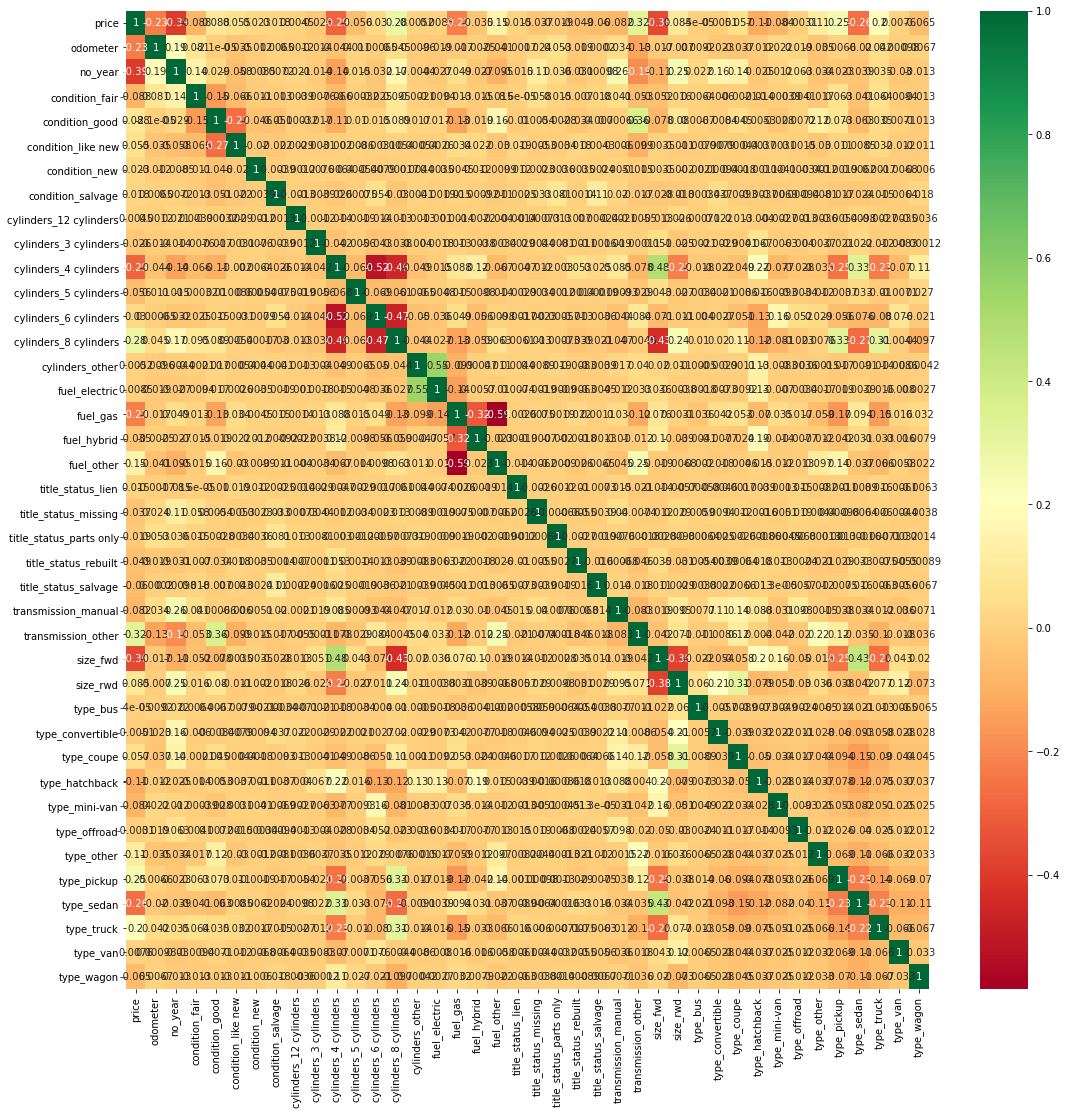

In [21]:
#get correlations of each features in dataset
plt.figure(figsize=(18,18))
sns.heatmap(final_dataset.corr(),annot=True,cmap='RdYlGn')
plt.show()

In [25]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)


[]


In [28]:
df1 = final_dataset.drop(final_dataset.columns[to_drop], axis=1)
print(); print(df1.head(10))


   price  odometer  no_year  condition_fair  condition_good  \
0  15000  128000.0        7               0               0   
1  27990   68696.0        8               0               1   
2  34590   29499.0        4               0               1   
3  35000   43000.0        1               0               0   
4  29990   17302.0        4               0               1   
5  38590   30237.0        9               0               1   
6  32990   30041.0        3               0               1   
7  30990   34940.0        4               0               1   
8  37990    9704.0        4               0               1   
9  27990   37332.0        2               0               1   

   condition_like new  condition_new  condition_salvage  \
0                   0              0                  0   
1                   0              0                  0   
2                   0              0                  0   
3                   0              0                  0   
4         

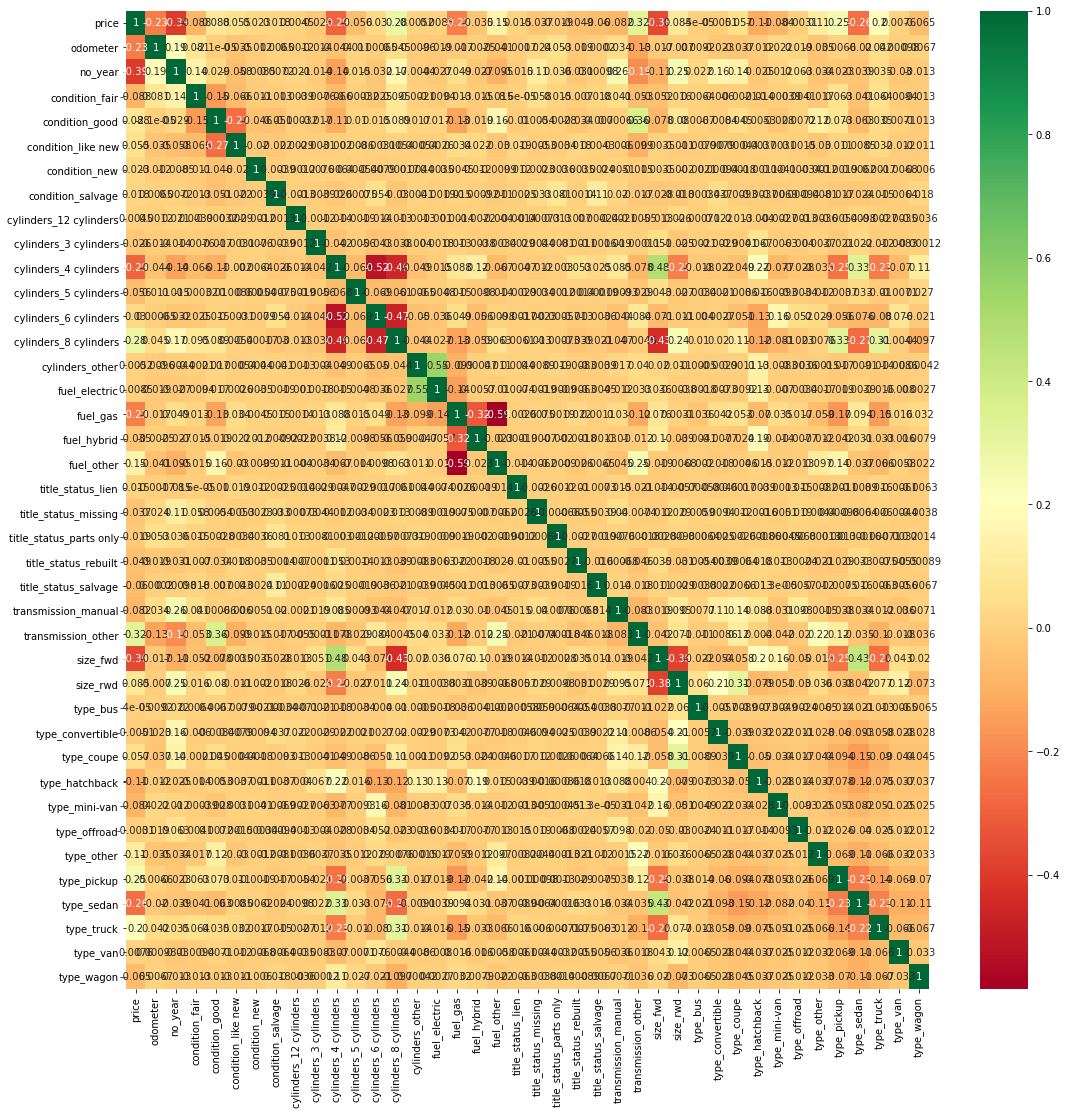

In [29]:
#get correlations of each features in dataset
plt.figure(figsize=(18,18))
sns.heatmap(df1.corr(),annot=True,cmap='RdYlGn')
plt.show()

In [ ]:
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
#print()
#print(to_drop)

In [ ]:
#df3 = df.drop(df.columns[to_drop], axis=1)
#print()
#print(df3.head())

In [ ]:
X=final_dataset.iloc[:,1:]
y=final_dataset.iloc[:,0]

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
### Feature Importance
### improve the predictive accuracy and control over-fitting.
model = ExtraTreesRegressor()
model.fit(X,y)

In [ ]:
print(model.feature_importances_)

In [ ]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
feat_importances.sort_values(ascending=False)

In [ ]:
features_to_use=feat_importances.sort_values(ascending=False).index.values[:10]
features_to_use

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [ ]:
random= RandomForestRegressor()
param_grid={
    'max_depth':[3,5,9,10,None],
    'min_samples_leaf':[1,2,4],
    'min_samples_split':[2,5,10],
    'n_estimators':[100,200]  
}

In [ ]:
regressor=RandomForestRegressor()

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

In [ ]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [ ]:
rf_random.fit(X_train,y_train)

In [ ]:
rf_random.best_params_

In [ ]:
rf_random.best_score_

In [ ]:
predictions=rf_random.predict(X_test)

In [ ]:
sns.distplot(y_test-predictions)

In [ ]:
plt.scatter(y_test,predictions)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
print("Accuracy on Traing set: ",rf_random.score(X_train,y_train))
print("Accuracy on Testing set: ",rf_random.score(X_test,y_test))